In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Simple A/B Test: Add-to-Cart Button Color (Blue vs Green)

**Author:** Radhika Patil  
**Goal:** Test whether changing the Add-to-Cart button from Blue (A) to Green (B) increases Add-to-Cart rate.

This notebook simulates data, runs a two-proportion z-test, plots results, and gives a simple conclusion.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import os

sns.set(style="whitegrid")
os.makedirs("dashboard/screenshots", exist_ok=True)


In [2]:
# Parameters: adjust these to simulate different traffic or baseline
np.random.seed(42)
n_per_variant = 20000    # number of users exposed to each variant
baseline_atc = 0.064     # baseline add-to-cart rate (6.4%)
effect_relative = 0.10   # simulate a 10% relative lift (change to ~7.04%)

# Compute true probabilities
p_A = baseline_atc
p_B = baseline_atc * (1 + effect_relative)

# Simulate Bernoulli outcomes: 1 = user added to cart, 0 = did not
data_A = np.random.binomial(1, p_A, n_per_variant)
data_B = np.random.binomial(1, p_B, n_per_variant)

# Summarize
success_A = data_A.sum()
success_B = data_B.sum()
n_A = len(data_A)
n_B = len(data_B)

print(f"A (Blue)   : successes = {success_A} / {n_A}  => rate = {success_A/n_A:.4f}")
print(f"B (Green)  : successes = {success_B} / {n_B}  => rate = {success_B/n_B:.4f}")


A (Blue)   : successes = 1288 / 20000  => rate = 0.0644
B (Green)  : successes = 1387 / 20000  => rate = 0.0693


In [3]:
# Two-proportion z-test: test H0: p_B == p_A  vs  H1: p_B != p_A
count = np.array([success_B, success_A])   # order: [success_B, success_A]
nobs = np.array([n_B, n_A])

stat, pval = proportions_ztest(count, nobs)
print("z-statistic = {:.3f}, p-value = {:.4f}".format(stat, pval))

# Compute absolute & relative lift
rate_A = success_A / n_A
rate_B = success_B / n_B
abs_lift = rate_B - rate_A
rel_lift = abs_lift / rate_A * 100
print(f"Absolute lift = {abs_lift:.4f} ({abs_lift*100:.2f} pp)")
print(f"Relative lift = {rel_lift:.2f}%")


z-statistic = 1.982, p-value = 0.0475
Absolute lift = 0.0049 (0.49 pp)
Relative lift = 7.69%


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


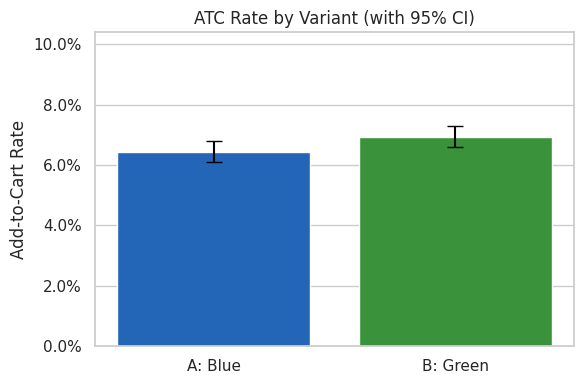

In [11]:
# Bar plot with rates and 95% CI (approx)
import math
from statsmodels.stats.proportion import proportion_confint

# compute 95% CI for proportions (normal approximation / or use exact)
ci_A_low, ci_A_high = proportion_confint(success_A, n_A, alpha=0.05, method='wilson')
ci_B_low, ci_B_high = proportion_confint(success_B, n_B, alpha=0.05, method='wilson')

rates = [rate_A, rate_B]
ci_lows = [ci_A_low, ci_B_low]
ci_highs = [ci_A_high, ci_B_high]
labels = ['A: Blue', 'B: Green']

plt.figure(figsize=(6,4))
sns.barplot(x=labels, y=rates, palette=['#0b63ce', '#2ca02c'])
# add error bars
plt.errorbar(x=[0,1], y=rates, yerr=[np.array(rates)-np.array(ci_lows), np.array(ci_highs)-np.array(rates)],
             fmt='none', c='black', capsize=6)
plt.ylim(0, max(rates)*1.5)
plt.ylabel('Add-to-Cart Rate')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.title('ATC Rate by Variant (with 95% CI)')
plt.tight_layout()

# Save chart
plt.savefig("dashboard/screenshots/ab_button_color_atc.png", dpi=150)
plt.show()


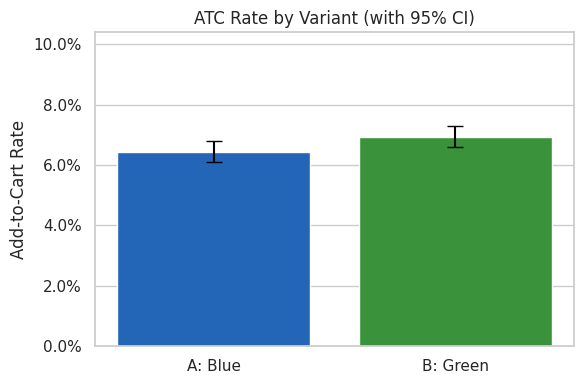

In [6]:
# Bar plot with rates and 95% CI (approx)
import math
from statsmodels.stats.proportion import proportion_confint

# compute 95% CI for proportions (normal approximation / or use exact)
ci_A_low, ci_A_high = proportion_confint(success_A, n_A, alpha=0.05, method='wilson')
ci_B_low, ci_B_high = proportion_confint(success_B, n_B, alpha=0.05, method='wilson')

rates = [rate_A, rate_B]
ci_lows = [ci_A_low, ci_B_low]
ci_highs = [ci_A_high, ci_B_high]
labels = ['A: Blue', 'B: Green']

plt.figure(figsize=(6,4))
sns.barplot(x=pd.Index(labels), y=rates, palette=['#0b63ce', '#2ca02c'])

# add error bars
plt.errorbar(x=[0,1], y=rates, yerr=[np.array(rates)-np.array(ci_lows), np.array(ci_highs)-np.array(rates)],
             fmt='none', c='black', capsize=6)
plt.ylim(0, max(rates)*1.5)
plt.ylabel('Add-to-Cart Rate')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.title('ATC Rate by Variant (with 95% CI)')
plt.tight_layout()

# Save chart
plt.savefig("dashboard/screenshots/ab_button_color_atc.png", dpi=150)
plt.show()


## Simple conclusion 

Result:** Variant B (Green) had an ATC rate of **{:.2%}** vs A (Blue) **{:.2%}**.  
  (Absolute lift = {:.2%}, Relative lift = {:.2f}% — z-stat={:.3f}, p={:.4f})

Interpretation (plain): The green button got more users to add items to their cart.  Recommendation:Roll out the green button and then measure downstream purchase rate to ensure carts convert to purchases.


